### Meridional structure of the amplitude of the mean seasonal cycle of PR in the eastern Pacific

Computes the meridional root mean square error (RMSE) of eastern Pacific (15°S-15°N) amplitude (standard deviation) of the mean annual cycle (zonal 150-90°W average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

This notebook computes the meridional root mean square error (RMSE) of the amplitude of the mean seasonal cycle of precipitation (PR) between model simulations and observations over the eastern Pacific region (15°S–15°N, 150°W–90°W).

The analysis involves:

- Zonal Averaging: Averaging precipitation data between 150°W and 90°W for both model output and observations.
- Seasonal Cycle Analysis: Computing the mean annual cycle (12-month time series) at each latitude by averaging monthly precipitation over the analysis period.
- Amplitude Calculation: Determining the standard deviation of the mean annual cycle at each latitude to quantify its amplitude.
- Meridional RMSE: Calculating the RMSE between model and observational amplitudes to evaluate the model's ability to replicate the observed seasonal cycle.

### Observations and reanalysis datasets used for comparison

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.

These datasets provide a range of perspectives on precipitation patterns, helping to assess the model’s performance more robustly.

## Dask Cluster  
Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client
client = Client() #threads_per_worker = 1?
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41579,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41201,Total threads: 2
Dashboard: /proxy/42243/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:34245,


2025-08-28 16:46:02,664 - distributed.nanny - WARNING - Restarting worker


In [2]:
# ACCESS MOPPeR ESM1.6
import glob
from access_mopper import ACCESS_ESM_CMORiser

ROOT_FOLDER = (
    "/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/JuneSpinUp-JuneSpinUp-bfaa9c5b/"
)

OUTPUT_FOLDER = "/scratch/nf33/fc6164/"

parent_experiment_config = {
    "parent_experiment_id": "piControl",
    "parent_activity_id": "CMIP",
    "parent_source_id": "ACCESS-ESM1-5",
    "parent_variant_label": "r1i1p1f1",
    "parent_time_units": "days since 0001-01-01 00:00:00",
    "parent_mip_era": "CMIP6",
    "branch_time_in_child": 0.0,
    "branch_time_in_parent": 54786.0,
    "branch_method": "standard",
}


Loaded Configuration:
Creator Name: felicity Chun
Organisation: ACCESS-NRI
Creator Email: felicity.chun@anu.edu.au
Creator URL: 0009-0007-0845-0953


In [5]:
FILES = glob.glob(ROOT_FOLDER + "output[0-1][0-9][0-9]/atmosphere/netCDF/*mon.nc")
len(FILES)

2400

In [6]:
cmoriser = ACCESS_ESM_CMORiser(
    input_paths=FILES,
    compound_name="Amon.pr",
    experiment_id="piControl",
    source_id="ACCESS-ESM1-5",
    variant_label="r1i1p1f1",
    grid_label="gn",
    activity_id="CMIP",
    output_path=OUTPUT_FOLDER,
    parent_info=parent_experiment_config, # <-- This is optional, can be skipped if not needed
    )

In [7]:
cmoriser.run()
# cmoriser.write()
esm16_cube = cmoriser.to_iris()[0] #test no ncdata in analysis3

ImportError: ncdata and iris are required for to_iris(). Please install ncdata and iris.

In [8]:
# to xarray dataset
cmoriser.to_dataset()

<xarray.Dataset> Size: 267MB
Dimensions:    (lat: 145, bnds: 2, lon: 192, time: 2400)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time       (time) float64 19kB 3.985e+05 3.985e+05 ... 4.715e+05 4.715e+05
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    time_bnds  (time, bnds) float64 38kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    pr         (lon, lat, time) float32 267MB dask.array<chunksize=(192, 145, 1), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    creation_date:          2025-08-28T06:21:03Z
    data_specs_version:     01.00.33
    experiment:             pre-industrial control
    experiment_id:          piControl
    ...                     ...
    branch_method:          standard
    external_variables:     areacella
    creator_name:           felicity Chun
    creator_organisation:   ACCESS-NRI
    creator_email:          felicity.chun@anu.edu.au
    creator_url:            0009-0007-0845-0953

In [10]:
ds = cmoriser.to_dataset()
esm16_cube = ds.pr.to_iris()

## Datasets

In [11]:
from esmvalcore.dataset import Dataset

In [12]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="piControl",
    ensemble="r1i1p1f1",
    # timerange="18500101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    timerange="19790101/20190101",
    tier=2),
}

## Add Ancillary files


In [13]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [14]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/v20210316/sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc)


In [15]:
from esmvalcore.preprocessor import zonal_statistics
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
# from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import climate_statistics

import iris
import numpy as np

In [16]:
def preproc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = mask_landsea(cube, mask_out="land")
    cube = convert_units(cube, units="mm/day")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    return cube

def preproc2(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    cube = zonal_statistics(cube, 'mean')
    
    return cube

# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

In [17]:
model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

esm16_prep1 = preproc1(esm16_cube)

model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}
esm16_prep2 = preproc2(esm16_cube)

## Diagnostics Level 1

In [20]:
esm16_prep2.data # errors around computing data

Exception ignored in: <function CachingFileManager.__del__ at 0x1525f9dc8180>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID
Exception ignored in: <function CachingFileManager.__del__ at 0x1458a29b7ec0>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__

masked_array(data=[0.6417472958564758, 0.7389907836914062,
                   0.922990083694458, 1.3060035705566406,
                   1.924477458000183, 2.7045657634735107,
                   3.530463218688965, 4.267812728881836,
                   4.430054664611816, 4.15508508682251,
                   3.4118189811706543, 2.35349178314209,
                   1.2916920185089111, 0.586688220500946,
                   0.3163570463657379, 0.39344584941864014,
                   0.7169150114059448, 1.3171935081481934,
                   2.062659740447998, 2.809271812438965,
                   3.391721487045288, 4.2064290046691895,
                   5.651622295379639, 6.118699550628662, 6.01929235458374,
                   5.489475727081299, 4.6136932373046875,
                   3.631882429122925, 2.779235363006592,
                   2.1493873596191406],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, Fals

  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID
Exception ignored in: <function CachingFileManager.__del__ at 0x1525f9dc8180>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


Text(0.5, 0, 'Latitude')

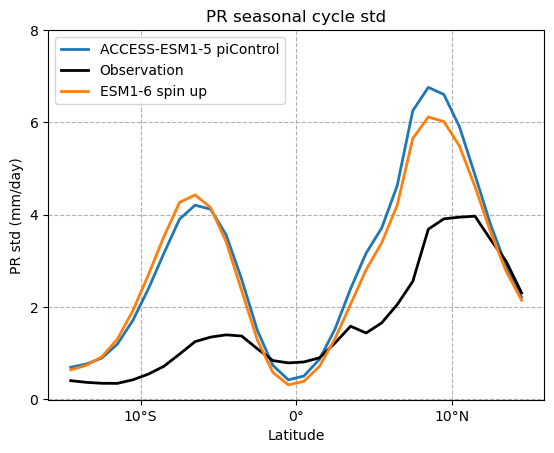

In [21]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt

#plot 1
def format_latitude(x):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]
error = rmse(obs_data, model_data)

qplt.plot(model_data, label='ACCESS-ESM1-5 piControl', linewidth=2)
qplt.plot(obs_data, color='black', label='Observation', linewidth=2)
qplt.plot(esm16_prep2, label='ESM1-6 spin up', linewidth=2)

# plt.text(0.5, 0.95, f'RMSE: {error:.2f}', fontsize=12, ha='center', transform=plt.gca().transAxes,
#          bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
# ax = plt.gca()
plt.grid(linestyle='--')
plt.title('PR seasonal cycle std')

plt.yticks(np.arange(0,9, step=2))
plt.ylabel('PR std (mm/day)')

xt = np.arange(-10,15,step=10)
xlab = [format_latitude(x) for x in xt]
plt.xticks(xt,xlab)
plt.xlabel('Latitude')

Figure 1: Meridional bias in the amplitude of the mean seasonal precipitation cycle (PR) in the eastern Pacific (averaged between 150–90°W).

## Diagnostics level 2

Exception ignored in: <function CachingFileManager.__del__ at 0x1458a29b7ec0>
Exception ignored in: <function CachingFileManager.__del__ at 0x1525f9dc8180>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
    self.close(needs_lock=False)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
    file.close()
  File

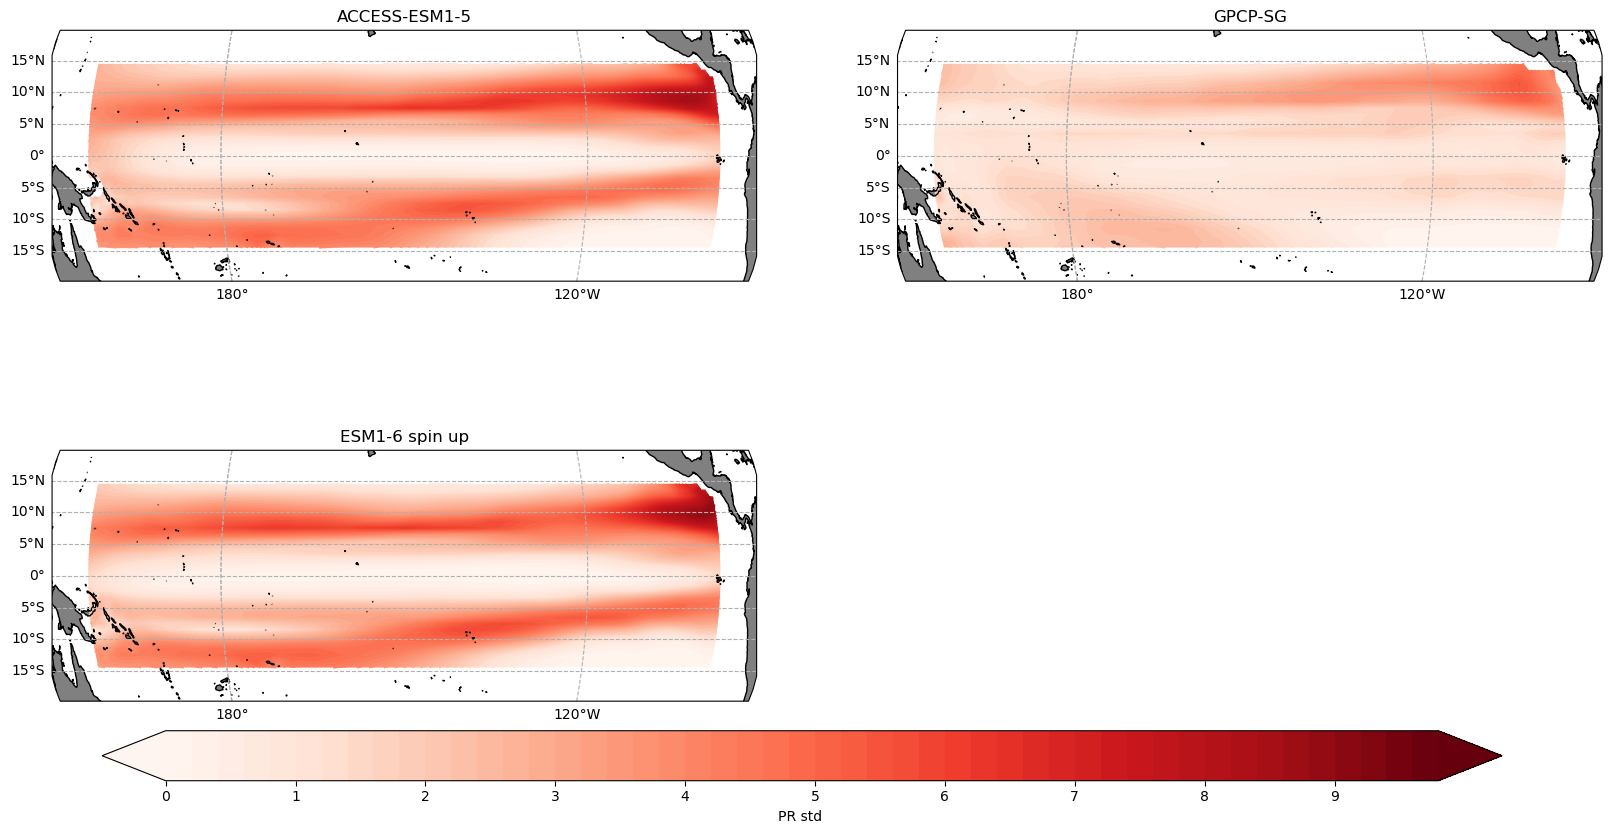

In [22]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
proj = ccrs.Orthographic(central_longitude=210.0)
i =221
process = {**model_datasets_prep1, **obs_datasets_prep1, 'ESM1-6 spin up': esm16_prep1}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,10,0.2), extend='both', cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,10,1))
cbar.set_label('PR std ')

Figure 2: Bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Pacific.

# Diagnostic level 3

The third level shows the meridional structure of the mean seasonal cycle in a Hovmöller diagram

In [23]:
def preproc3(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = zonal_statistics(cube, operator='mean')
    
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
esm16_prep3 = preproc3(esm16_cube)

process = {**model_datasets_prep3, 'ESM1-6 spin up': esm16_prep3}


In [28]:
esm16_prep3.data #computes
esm16_prep3.data.mean()

4.119402398003472

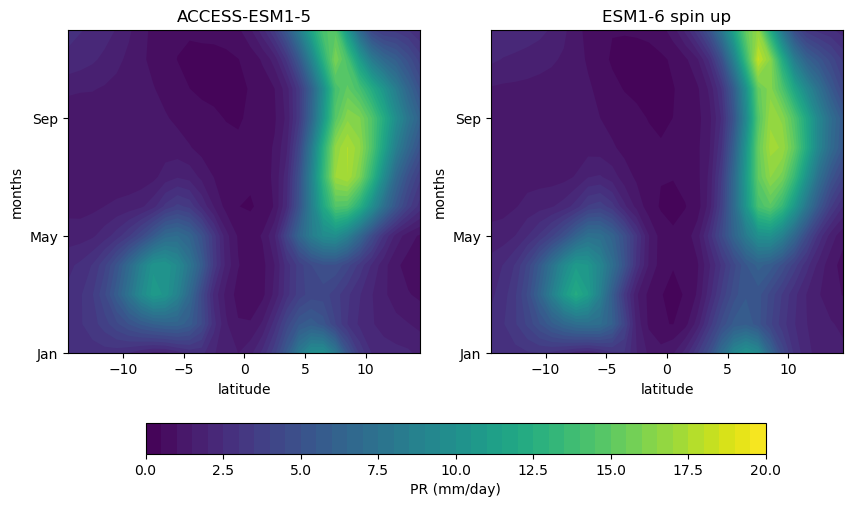

In [29]:
fig = plt.figure(figsize=(10, 6))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 4)
month_labels =['Jan', 'May', 'Sep'] 

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['latitude','month_number'],levels=np.arange(0,20.5,0.5),cmap="viridis")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("latitude")
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('PR (mm/day)')

Figure 3: Meridional structure of the mean seasonal cycle of precipitation (PR) in the eastern Pacific (averaged between 150–90°W).

In [30]:
client.close()

2025-08-28 16:53:20,129 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-08-28 16:53:20,130 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-08-28 16:53:20,131 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-08-28 16:53:20,132 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-08-28 16:53:20,135 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-08-28 16:53:20,135 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
